In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
import pyswarms as ps

from tensorflow import keras
from keras import layers, models
from keras import losses

import logging

In [48]:
index = 'AMD'
df = pdr.get_data_yahoo(index, start=None, end=None)

[*********************100%%**********************]  1 of 1 completed


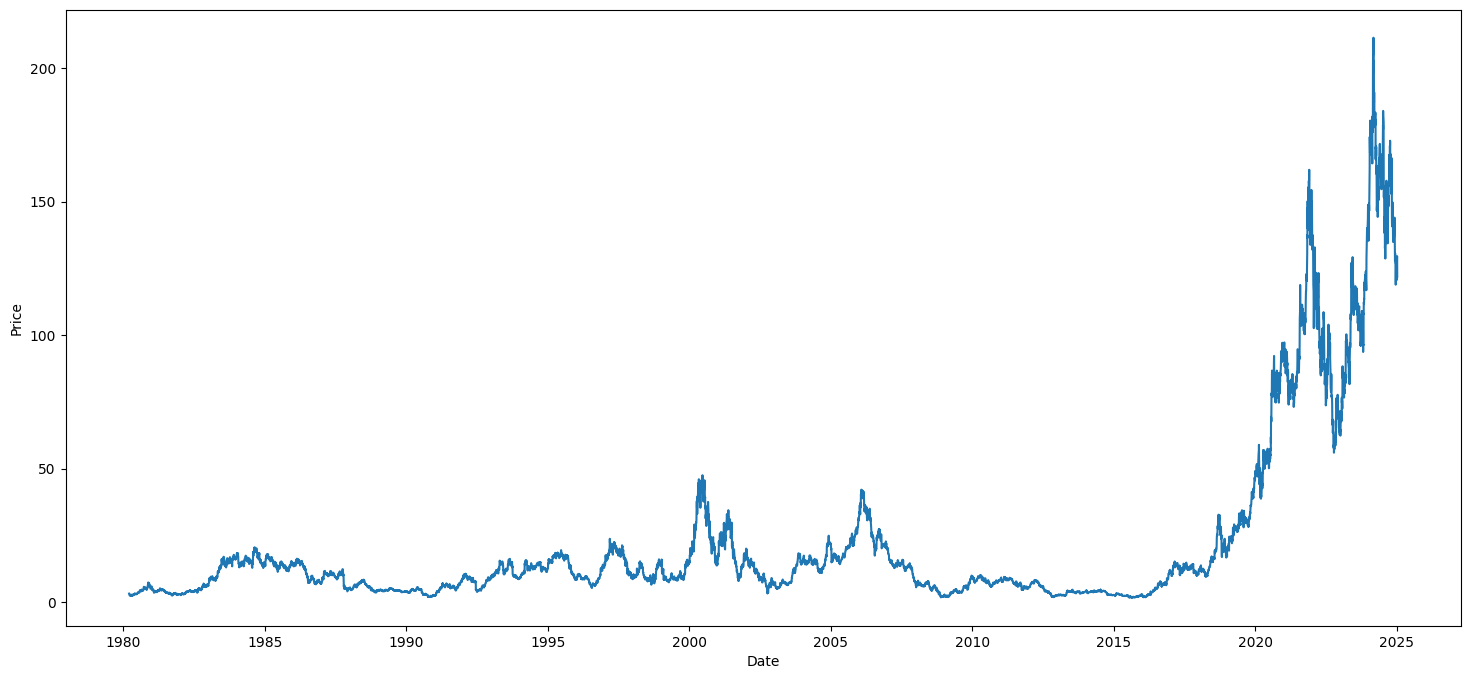

In [49]:
plt.figure(figsize=(18,8))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [50]:
# Get total number of years in the dataset
years = (df.index[-1] - df.index[0]).days / 365.25
print(years)
df
print(f"{index} & {round(years)} & {round(years*0.65)} & {round(years*0.35)}")

44.813141683778234
AMD & 45 & 29 & 16


In [51]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.000000,3.302083,3.125000,3.145833,3.145833,219600
1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200
1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200
1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600
1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800
...,...,...,...,...,...,...
2025-01-02,122.290001,123.139999,119.440002,120.629997,120.629997,34256200
2025-01-03,121.650002,125.559998,121.419998,125.370003,125.370003,36785300
2025-01-06,129.070007,130.729996,127.360001,129.550003,129.550003,48020200


In [4]:
data = df.filter(['Close']) # should return a 2D array for the closing prices. Return type is a DataFrame

training_split_length = int(np.ceil(len(data)*0.65))

dataset = data.values # Return type of .values is a numpy.ndarray of dim 2

scalar = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scalar.fit_transform(dataset)

scaled_dataset.shape

(24307, 1)

In [14]:
def split_data(prev_days, scaled_dataset, training_split_length, dia):
    train_data = scaled_dataset[:int(training_split_length), :]
    x_train = []
    y_train = []
    for i in range(prev_days, len(train_data) - dia):
        x_train.append(train_data[i - prev_days:i, 0])
        y_train.append(train_data[i + dia - 1])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

def create_model(layer_nodes, input_shape):
    model = keras.Sequential()
    for i, nodes in enumerate(layer_nodes):
        return_sequences = i < len(layer_nodes) - 1
        if i == 0:
            model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences))
    model.add(keras.layers.Dense(1))
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def evaluate_model(hyperparameters, scaled_dataset, training_split_length):
    layers = int(hyperparameters[0])  
    layer_nodes = [int(n) for n in hyperparameters[1:1 + layers]]  
    batch_size, epochs, prev_days = int(hyperparameters[1 + max_layers]), int(hyperparameters[2 + max_layers]), int(hyperparameters[3 + max_layers])
    
    print(f"Layers: {layers}. Layer Nodes: {layer_nodes}. Batch Size: {batch_size}. Epochs: {epochs}. Previous Days: {prev_days}")

    x_train, y_train = split_data(prev_days, scaled_dataset, training_split_length, dia=4)
    model = create_model(layer_nodes, input_shape=(x_train.shape[1], 1))
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    val_loss = np.min(history.history['mean_squared_error'])
    return val_loss

def objective_function(hyperparameters, scaled_dataset, training_split_length):
    n_particles = hyperparameters.shape[0]
    j = [evaluate_model(hyperparameters[i], scaled_dataset, training_split_length) for i in range(n_particles)]
    return np.array(j)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_layers = 5  

# Layers, Nodes per layer, Batch size, Epochs, Previous days
lower_bounds = [1] + [10]*max_layers + [32, 10, 10]
upper_bounds = [max_layers] + [100]*max_layers + [64, 20, 100]
bounds = (lower_bounds, upper_bounds)

#Initialize swarm
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=len(lower_bounds), options=options, bounds=bounds)

#Perform optimization
cost, pos = optimizer.optimize(objective_function, iters=5, scaled_dataset=scaled_dataset, training_split_length=training_split_length)

# Best hyperparameters
print(f"Best Hyperparameters are: {pos}")

2024-10-05 15:05:28,714 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/5

Layers: 3. Layer Nodes: [58, 20, 40]. Batch Size: 40. Epochs: 11. Previous Days: 27
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 27, 58)            13920     
                                                                 
 lstm_25 (LSTM)              (None, 27, 20)            6320      
                                                                 
 lstm_26 (LSTM)              (None, 40)                9760      
                                                                 
 dense_8 (Dense)             (None, 1)                 41        
                                                                 
Total params: 30041 (117.35 KB)
Trainable params: 30041 (117.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


pyswarms.single.global_best:   0%|          |0/5


KeyboardInterrupt: 

In [ ]:
# prev_days = int(pos[3 + max_layers])
# x_train, y_train = split_data(prev_days, scaled_dataset, training_split_length, dia=4)
# layer_nodes = [int(n) for n in pos[1:1+max_layers]]
# model = create_model(layer_nodes, input_shape=(x_train.shape[1], 1))

# batch_size, epochs = int(pos[1 + max_layers]), int(pos[2 + max_layers])

# history = model.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=epochs)


"""
Code below should be the corrected layers.
"""

print(pos)

layers = int(pos[0])
print(layers)

prev_days = int(pos[3 + max_layers])
x_train, y_train = split_data(prev_days, scaled_dataset, training_split_length, dia=4)
layer_nodes = [int(n) for n in pos[1:1+layers]]

print(prev_days)
print(layer_nodes)
model = create_model(layer_nodes, input_shape=(x_train.shape[1], 1))

batch_size, epochs = int(pos[1 + max_layers]), int(pos[2 + max_layers])

history = model.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/15
86/86 [==============================] - 6s 9ms/step - loss: 9.7094e-05 - mean_squared_error: 9.7094e-05 - mean_absolute_error: 0.0057
Epoch 2/15
86/86 [==============================] - 1s 9ms/step - loss: 5.7296e-06 - mean_squared_error: 5.7296e-06 - mean_absolute_error: 0.0016
Epoch 3/15
86/86 [==============================] - 1s 9ms/step - loss: 5.4486e-06 - mean_squared_error: 5.4486e-06 - mean_absolute_error: 0.0016
Epoch 4/15
86/86 [==============================] - 1s 9ms/step - loss: 5.8299e-06 - mean_squared_error: 5.8299e-06 - mean_absolute_error: 0.0017
Epoch 5/15
86/86 [==============================] - 1s 9ms/step - loss: 5.3575e-06 - mean_squared_error: 5.3575e-06 - mean_absolute_error: 0.0016
Epoch 6/15
86/86 [==============================] - 1s 9ms/step - loss: 5.7072e-06 - mean_squared_error: 5.7072e-06 - mean_absolute_error: 0.0017
Epoch 7/15
86/86 [==============================] - 1s 9ms/step - loss: 5.5219e-06 - mean_squared_error: 5.5219e-06 - mean_a

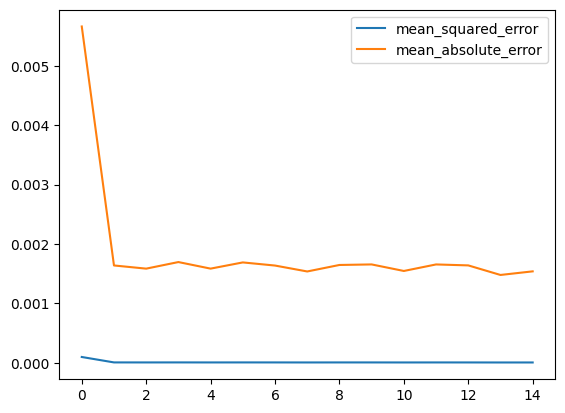

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['mean_squared_error', 'mean_absolute_error'])
plt.show()

In [ ]:
test_data = scaled_dataset[training_split_length-int(pos[-1]):,:]
x_test = []
y_test = dataset[training_split_length:, :]
for i in range(int(pos[-1]), len(test_data)):
    x_test.append(test_data[i-int(pos[-1]):i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test)**2)))

rmse

74/74 [==============================] - 1s 4ms/step


12.160474635689166

In [30]:
diff = (np.max(dataset[training_split_length:])) - (np.min(dataset[training_split_length:]))
norm_rmse = 2.69336452210665/diff
norm_rmse



0.01563882053178519

<ipython-input-31-0234d146b869>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,:]


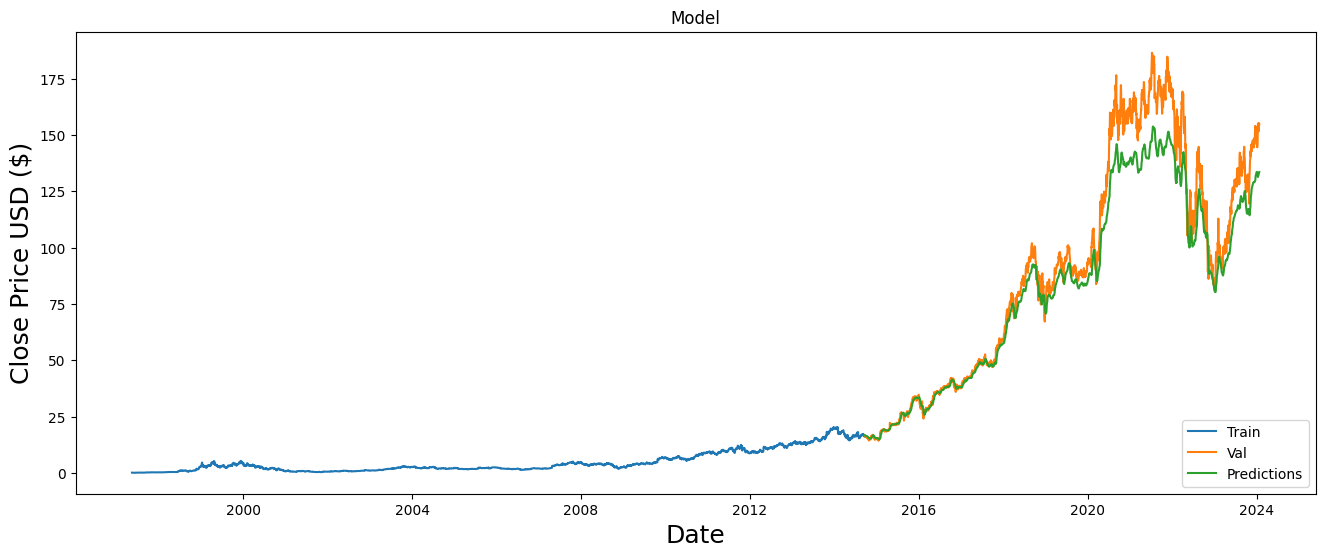

In [31]:
train = data[:training_split_length]
valid = data[training_split_length:]
valid['Predictions'] = predictions[:,:]
#Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
close_price = valid['Close'].values
prediction_price = valid['Predictions'].values
accuracy = lambda close, pred: min(close, pred)/max(close, pred) * 100
accuracy_lst = np.array([accuracy(close, pred) for close,pred in zip(close_price, prediction_price)])
accuracy = np.average(accuracy_lst)
accuracy

93.01236521507542

In [ ]:
late_test = scaled_dataset[-int(pos[4]):,:]
late_test = np.reshape(late_test, (1, int(pos[4]), 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 25ms/step


array([[140.41953]], dtype=float32)

In [ ]:
late_test = scaled_dataset[-33:-3,:]
late_test = np.reshape(late_test, (1, 30, 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 22ms/step


array([[149.40627]], dtype=float32)

In [ ]:
data.iloc[-33:-3,:]

,Close
Date,
2023-12-29,151.940002
2024-01-02,149.929993
2024-01-03,148.470001
2024-01-04,144.570007
2024-01-05,145.240005


In [ ]:
valid

,Close,Predictions
Date,,
2023-10-05,125.959999,128.367264
2023-10-06,127.959999,128.563629
2023-10-09,128.259995,128.504883
2023-10-10,129.479996,127.838013
2023-10-11,131.830002,128.783081
...,...,...
2024-01-04,144.570007,152.308731
2024-01-05,145.240005,151.080307
2024-01-08,149.100006,149.406265
